### Setup

Import Caffe and the usual modules.

In [2]:
import sys
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.mlab import PCA

%matplotlib inline

#plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make sure that caffe is on the python path:
caffe_root = '../../'  # this file is expected to be in {caffe_root}/examples/triplet_LINEMOD
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

### Load the trained net

Load the model definition and weights and set to CPU mode TEST phase computation with input scaling.

In [ ]:
MODEL_FILE = '3d_triplet.prototxt'
PRETRAINED_FILE = 'linemod_triplet_1_iter_1200000.caffemodel' 
caffe.set_mode_gpu()
net_test = caffe.Net(MODEL_FILE, PRETRAINED_FILE, caffe.TEST)

net_img = caffe.io.load_image(caffe_root + 'examples/triplet_LINEMOD/3d_triplet_net_architecture.png')
plt.figure(figsize=(32, 9))
plt.imshow(net_img)

### Load thumbnails for 15 categories in LINEMOD dataset

LINEMOD sample data visualization

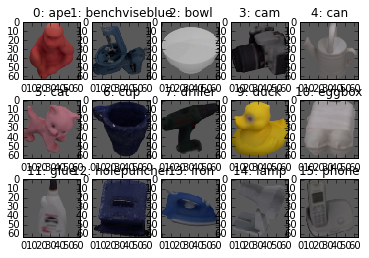

In [4]:
# 15 classes in LINEMOD dataset
ape_img = caffe.io.load_image('/home/hy/wb/LINEMOD/ape/cropped/train/rgb385.png', color=True)
benchviseblue_img = caffe.io.load_image('/home/hy/wb/LINEMOD/benchviseblue/cropped/train/rgb396.png', color=True)
bowl_img = caffe.io.load_image('/home/hy/wb/LINEMOD/bowl/cropped/train/rgb385.png', color=True)
cam_img = caffe.io.load_image('/home/hy/wb/LINEMOD/cam/cropped/train/rgb388.png', color=True)
can_img = caffe.io.load_image('/home/hy/wb/LINEMOD/can/cropped/train/rgb385.png', color=True)
cat_img = caffe.io.load_image('/home/hy/wb/LINEMOD/cat/cropped/train/rgb382.png', color=True)
cup_img = caffe.io.load_image('/home/hy/wb/LINEMOD/cup/cropped/train/rgb389.png', color=True)
driller_img = caffe.io.load_image('/home/hy/wb/LINEMOD/driller/cropped/train/rgb386.png', color=True)
duck_img = caffe.io.load_image('/home/hy/wb/LINEMOD/duck/cropped/train/rgb386.png', color=True)
eggbox_img = caffe.io.load_image('/home/hy/wb/LINEMOD/eggbox/cropped/train/rgb385.png', color=True)
glue_img = caffe.io.load_image('/home/hy/wb/LINEMOD/glue/cropped/train/rgb385.png', color=True)
holepuncher_img = caffe.io.load_image('/home/hy/wb/LINEMOD/holepuncher/cropped/train/rgb385.png', color=True)
iron_img = caffe.io.load_image('/home/hy/wb/LINEMOD/iron/cropped/train/rgb387.png', color=True)
lamp_img = caffe.io.load_image('/home/hy/wb/LINEMOD/lamp/cropped/train/rgb389.png', color=True)
phone_img = caffe.io.load_image('/home/hy/wb/LINEMOD/phone/cropped/train/rgb427.png', color=True)

f_cls, axarr = plt.subplots(3, 5)
axarr[0,0].imshow(ape_img)
axarr[0,0].set_title('0: ape')
axarr[0,1].imshow(benchviseblue_img)
axarr[0,1].set_title('1: benchviseblue')
axarr[0,2].imshow(bowl_img)
axarr[0,2].set_title('2: bowl')
axarr[0,3].imshow(cam_img)
axarr[0,3].set_title('3: cam')
axarr[0,4].imshow(can_img)
axarr[0,4].set_title('4: can')

axarr[1,0].imshow(cat_img)
axarr[1,0].set_title('5: cat')
axarr[1,1].imshow(cup_img)
axarr[1,1].set_title('6: cup')
axarr[1,2].imshow(driller_img)
axarr[1,2].set_title('7: driller')
axarr[1,3].imshow(duck_img)
axarr[1,3].set_title('9: duck')
axarr[1,4].imshow(eggbox_img)
axarr[1,4].set_title('10: eggbox')

axarr[2,0].imshow(glue_img)
axarr[2,0].set_title('11: glue')
axarr[2,1].imshow(holepuncher_img)
axarr[2,1].set_title('12: holepuncher')
axarr[2,2].imshow(iron_img)
axarr[2,2].set_title('13: iron')
axarr[2,3].imshow(lamp_img)
axarr[2,3].set_title('14: lamp')
axarr[2,4].imshow(phone_img)
axarr[2,4].set_title('15: phone')

### Load some LINEMOD test data
the image data and label are binary

In [5]:
from struct import unpack
def swap_endian32(val):
    return (((val << 24) & 0xFF000000) |
            ((val << 8) & 0x00FF0000) |
            ((val >> 8) & 0x0000FF00) |
            ((val >> 24) & 0x000000FF))
    

TEST_DATA_FILE = '/home/hy/wb/LINEMOD/_test/binary_image'
TEST_LABEL_FILE = '/home/hy/wb/LINEMOD/_test/binary_label'
data_channel = 3
data_class = 15

with open(TEST_DATA_FILE, 'rb') as f:
    data_magic = unpack('i', f.read(4))[0]
    data_magic = swap_endian32(data_magic)
    if data_magic != 2051:
        print('Invalid binary data file\n')
        sys.exit()
    n = unpack('i', f.read(4))[0]
    n = swap_endian32(n)
    rows = unpack('i', f.read(4))[0]
    rows = swap_endian32(rows)
    cols = unpack('i', f.read(4))[0]
    cols = swap_endian32(cols)
    raw_test_data = np.fromstring(f.read(n*data_channel*64*64), dtype=np.uint8)
    print('test images size:%d rows:%d cols:%d\n' %(n, rows, cols))
    
with open(TEST_LABEL_FILE, 'rb') as f:
    label_magic = unpack('i', f.read(4))[0]
    label_magic = swap_endian32(label_magic)
    if label_magic != 2050:
        print('Invalid binary label file\n')
        sys.exit()
    n_l = unpack('i', f.read(4))[0]
    n_l = swap_endian32(n_l)
    test_labels_list = []
    for i in range(n_l):
        label_id_position = f.seek(8+i*4*4,0)
        label_id_val = unpack('i', f.read(4))[0]
        test_labels_list.append(label_id_val)
    test_labels_id = np.array(test_labels_list)
    print('test labels size:%d\n' %(n_l))
    
if n != n_l:
    print('Inconsistent data and label\n')
    sys.exit()

test images size:9141 rows:64 cols:64

test labels size:9141



### Generate the triplet features for test data

In [6]:
def net_forward_iter(net, data_in, iter_num):
    # Collect outputs from batches
    all_outs = {out: [] for out in list(net.blobs.keys())}
    for i in range(iter_num):
        a_in = data_in[i,:,:,:].reshape(1,data_in.shape[1],data_in.shape[2],data_in.shape[3])
        a_out = net.forward_all(data=a_in)      
        for out, out_blob in a_out.iteritems():
            all_outs[out].extend(out_blob.copy())
    # Package in ndarray.
    for out in all_outs:
        all_outs[out] = np.asarray(all_outs[out])
    return all_outs

# reshape and preprocess
caffe_test_in = raw_test_data.reshape(n, data_channel, rows, cols) * 0.00390625 # manually scale data instead of using `caffe.io.Transformer`
test_out = net_forward_iter(net_test, caffe_test_in, n)


### Visualize the learned triplet embedding 

visualize the last layer features

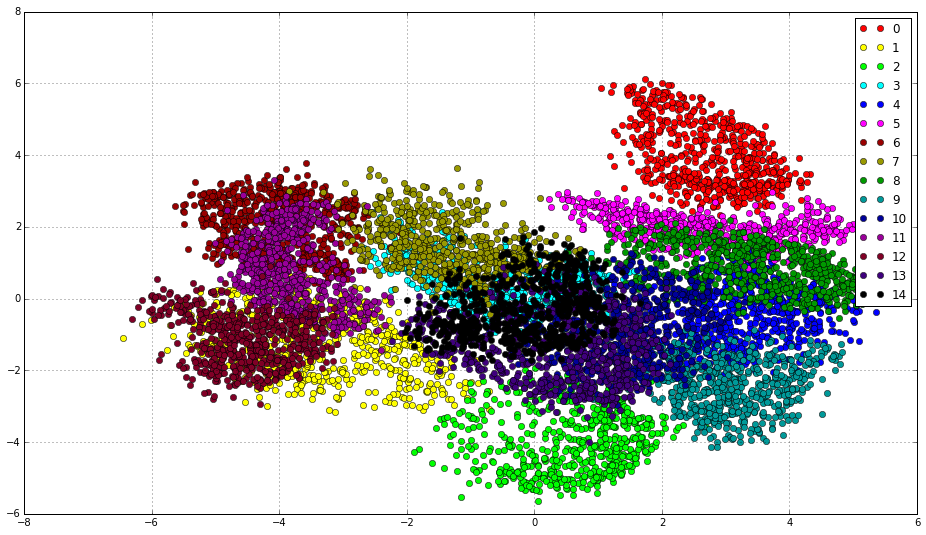

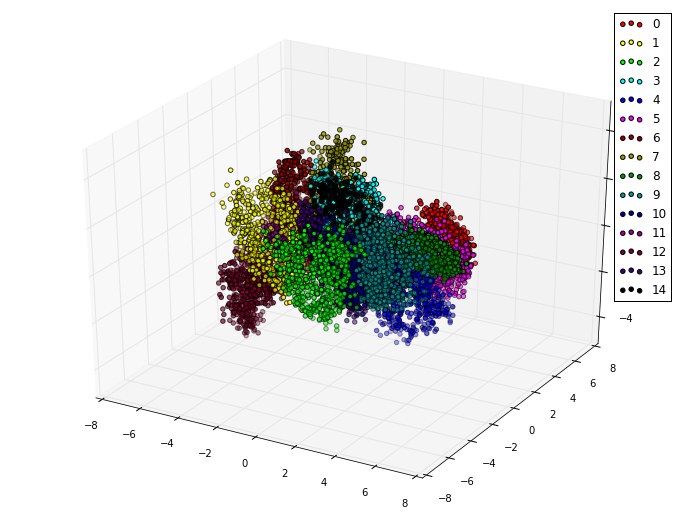

In [7]:
# the feature demension is 16, reduce the feature demension to 3 or 2 using PCA
# reference https://www.clear.rice.edu/comp130/12spring/pca/pca_docs.shtml
test_feat = test_out['feat']
test_feat_pca = PCA(test_feat)
test_feat_prj = test_feat_pca.Y

# 2d display
f2d = plt.figure(figsize=(16,9))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
    '#ff00ff', '#990000', '#999900', '#009900', '#009999',
    '#000099', '#990099', '#800026', '#3f007d', '#000000']
for i in range(data_class):
    plt.plot(test_feat_prj[test_labels_id==i,0].flatten(), test_feat_prj[test_labels_id==i,1].flatten(), 'o', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'])
plt.grid()
plt.show()

#3d display
f3d = plt.figure(figsize=(12,9))
ax = f3d.add_subplot(111, projection='3d')
for i in range(data_class):
    ax.scatter(test_feat_prj[test_labels_id==i,0].flatten(), test_feat_prj[test_labels_id==i,1].flatten(), test_feat_prj[test_labels_id==i,2].flatten(), c=c[i], marker='o')
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'])
plt.show()

### Visualize the weights

just visualize the first layer *conv1* and *conv2*

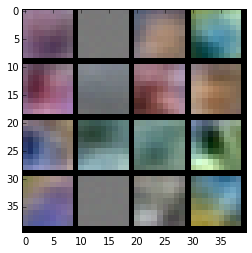

In [8]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])

    data = data.reshape(data.shape[0], data.shape[1], data.shape[2])
    plt.imshow(data)

conv1_w = net_test.params['conv1'][0].data
vis_square(conv1_w.transpose(0, 2, 3, 1))

### Load template data and Generate the triplet features for it

template images size:5115 rows:64 cols:64

template labels size:5115



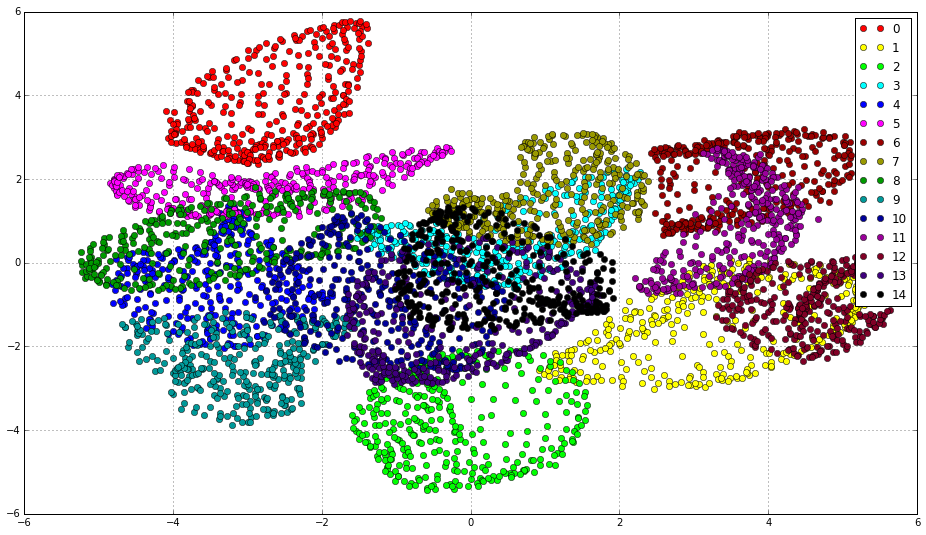

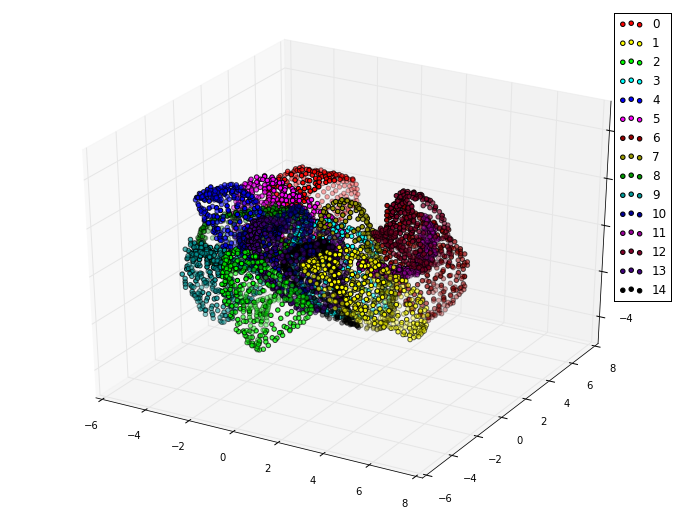

In [9]:
TMPL_DATA_FILE = '/home/hy/wb/LINEMOD/_tmpl/binary_image'
TMPL_LABEL_FILE = '/home/hy/wb/LINEMOD/_tmpl/binary_label'

with open(TMPL_DATA_FILE, 'rb') as f:
    data_magic = unpack('i', f.read(4))[0]
    data_magic = swap_endian32(data_magic)
    if data_magic != 2051:
        print('Invalid binary data file\n')
        sys.exit()
    n = unpack('i', f.read(4))[0]
    n = swap_endian32(n)
    rows = unpack('i', f.read(4))[0]
    rows = swap_endian32(rows)
    cols = unpack('i', f.read(4))[0]
    cols = swap_endian32(cols)
    raw_tmpl_data = np.fromstring(f.read(n*data_channel*64*64), dtype=np.uint8)
    print('template images size:%d rows:%d cols:%d\n' %(n, rows, cols))
    
with open(TMPL_LABEL_FILE, 'rb') as f:
    label_magic = unpack('i', f.read(4))[0]
    label_magic = swap_endian32(label_magic)
    if label_magic != 2050:
        print('Invalid binary label file\n')
        sys.exit()
    n_l = unpack('i', f.read(4))[0]
    n_l = swap_endian32(n_l)
    tmpl_labels_list = []
    for i in range(n_l):
        label_id_position = f.seek(8+i*4*4,0)
        label_id_val = unpack('i', f.read(4))[0]
        tmpl_labels_list.append(label_id_val)
    tmpl_labels_id = np.array(tmpl_labels_list)
    print('template labels size:%d\n' %(n_l))
    
if n != n_l:
    print('Inconsistent data and label\n')
    sys.exit()
    
    
# reshape and preprocess
caffe.set_mode_gpu()
net_tmpl = caffe.Net(MODEL_FILE, PRETRAINED_FILE, caffe.TEST)
caffe_tmpl_in = raw_tmpl_data.reshape(n, data_channel, rows, cols) * 0.00390625 # manually scale data instead of using `caffe.io.Transformer`
tmpl_out = net_forward_iter(net_tmpl, caffe_tmpl_in, n)

# visiulize
# the feature demension is 16, reduce the feature demension to 3 or 2 using PCA
# reference https://www.clear.rice.edu/comp130/12spring/pca/pca_docs.shtml
tmpl_feat = tmpl_out['feat']
tmpl_feat_pca = PCA(tmpl_feat)
tmpl_feat_prj = tmpl_feat_pca.Y

# 2d display
f2d = plt.figure(figsize=(16,9))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
    '#ff00ff', '#990000', '#999900', '#009900', '#009999',
    '#000099', '#990099', '#800026', '#3f007d', '#000000']
for i in range(data_class):
    plt.plot(tmpl_feat_prj[tmpl_labels_id==i,0].flatten(), tmpl_feat_prj[tmpl_labels_id==i,1].flatten(), 'o', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'])
plt.grid()
plt.show()

#3d display
f3d = plt.figure(figsize=(12,9))
ax = f3d.add_subplot(111, projection='3d')
for i in range(data_class):
    ax.scatter(tmpl_feat_prj[tmpl_labels_id==i,0].flatten(), tmpl_feat_prj[tmpl_labels_id==i,1].flatten(), tmpl_feat_prj[tmpl_labels_id==i,2].flatten(), c=c[i], marker='o')
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'])
plt.show()

### KNN for classification and pose estiamtion

In [10]:
LINEMOD_ROOT = '/home/hy/wb/LINEMOD'
OBJ_NAMES = ['ape', 'benchviseblue', 'bowl', 'cam', 'can', 'cat', 'cup', 'driller', 'duck', 
             'eggbox', 'glue', 'holepuncher', 'iron', 'lamp', 'phone']

#euclidean distance
def eu_distance(a, b, pow_order=2):
    ab_diff = np.subtract(a, b)
    ab_diff_p = np.power(ab_diff, pow_order)
    dist = np.sum(ab_diff_p)
    if dist==0:
        return 0
    else:
        return math.sqrt(dist)

from collections import OrderedDict
#brute force KNN
def KNN(point, points, k=1):
    points_num = points.shape[0]
    if k>points_num:
        print('The number of neighbors is out of range.')
        k = points_num
    
    tmp_dists = {}
    for i in range(points_num):
        dist = eu_distance(point, points[i,:])
        tmp_dists[str(i)] = dist
    nn_dists = OrderedDict(sorted(tmp_dists.items(), key=lambda t:t[1]))
    
    knn_ids = []
    knn_vals = []
    counter = 0
    for key,val in nn_dists.items():
        if counter<k:
            knn_ids.append(int(key))
            knn_vals.append(val) 
            counter = counter+1
        else:
            break
   
    return knn_ids, knn_vals

def triplet_classifer(knn_ids, class_num, tmpl_labels_id):
    k = len(knn_ids)
    knn_class_ids = []
    for i in range(k):
        point_id = knn_ids[i]
        knn_class_ids.append(tmpl_labels_id[point_id])
    cls_prob = []
    for i in range(class_num):
        curr_num = knn_class_ids.count(i)
        curr_prob = 100.0*curr_num/k
        cls_prob.append(curr_prob)
    max_prob_id = cls_prob.index(max(cls_prob))
    
    return max_prob_id, cls_prob

def triplet_pose_estimate(best_class_id, knn_ids, tmpl_labels_id, tmpl_poses_list):
    k = len(knn_ids)
    knn_class_ids = []
    for i in range(k):
        point_id = knn_ids[i]
        knn_class_ids.append(tmpl_labels_id[point_id])
    best_cls_first_point_ = knn_class_ids.index(best_class_id)
    best_cls_first_point_id = knn_ids[best_cls_first_point_]
    
    if best_class_id!=int(tmpl_poses_list[best_cls_first_point_id][0]):
        print('Label inconsistent.')
    subdir = tmpl_poses_list[best_cls_first_point_id][1]
    nn_img_name = tmpl_poses_list[best_cls_first_point_id][2]
    
    al_pose_file_path = '{0}/{1}/cropped/{2}_view_al.txt'.format(LINEMOD_ROOT,OBJ_NAMES[best_class_id],subdir)
    al_poses = [[x for x in line.strip().split(' ')] for line in open(al_pose_file_path).readlines()]
    for i in range(len(al_poses)):
        if al_poses[i][0]==nn_img_name:
            return float(al_poses[i][1]),float(al_poses[i][2]),float(al_poses[i][3]),float(al_poses[i][4])
    
    return None

def triplet_ground_truth_pose(point_id, test_poses_list):
    class_id = int(test_poses_list[point_id][0])
    subdir = test_poses_list[point_id][1]
    img_name = test_poses_list[point_id][2]
    al_pose_file_path = '{0}/{1}/cropped/{2}_view_al.txt'.format(LINEMOD_ROOT,OBJ_NAMES[class_id],subdir)
    al_poses = [[x for x in line.strip().split(' ')] for line in open(al_pose_file_path).readlines()]
    for i in range(len(al_poses)):
        if al_poses[i][0]==img_name:
            return float(al_poses[i][1]),float(al_poses[i][2]),float(al_poses[i][3]),float(al_poses[i][4])
    
    return None
    
# result analysis
# result analysis
# result analysis
test_points_num = test_feat.shape[0]
tmpl_points_num = tmpl_feat.shape[0]
test_pose_label_txt = '{0}/_test/label.txt'.format(LINEMOD_ROOT)
tmpl_pose_label_txt = '{0}/_tmpl/label.txt'.format(LINEMOD_ROOT)
test_poses_list = [[x for x in line.strip().split(' ')] for line in open(test_pose_label_txt).readlines()]
tmpl_poses_list = [[x for x in line.strip().split(' ')] for line in open(tmpl_pose_label_txt).readlines()]

K = 1
points_gt_ids = []
points_estimated_ids = []
errors = []
for i in range(test_points_num):
    knn_ids, knn_vals = KNN(test_feat[i,:], tmpl_feat, k=K)
    estimated_cls_id, estimated_cls_probs = triplet_classifer(knn_ids, data_class, tmpl_labels_id)
    estimated_pose = triplet_pose_estimate(estimated_cls_id, knn_ids, tmpl_labels_id, tmpl_poses_list)
    gt_pose = triplet_ground_truth_pose(i, test_poses_list)
    gt_cls_id = test_labels_id[i]
    error = math.fabs(estimated_pose[0]-gt_pose[0])+math.fabs(estimated_pose[1]-gt_pose[1])
    
    points_gt_ids.append(gt_cls_id)
    points_estimated_ids.append(estimated_cls_id)
    errors.append(error)
    
    #print('%d %d %f' %(gt_cls_id, estimated_cls_id, error))



### test data analysis and result visualization

99.676375
99.342105
99.351702
98.336106
97.993311
99.491525
98.387097
97.474747
100.000000
99.362041
97.213115
98.869144
99.305556
94.625407
95.337621


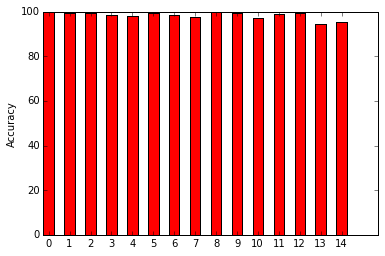

66.019417
56.578947
60.291734
68.885191
57.692308
67.457627
65.806452
53.198653
70.015949
65.869219
60.983607
69.143780
69.097222
59.934853
65.434084


In [11]:
# accuracy for per class
classification_accuracy_per_class = [0]*data_class
for i in range(test_points_num):
    points_estimated_id = points_estimated_ids[i]
    if points_gt_ids[i]==points_estimated_id:
        classification_accuracy_per_class[points_estimated_id] += 1
for i in range(data_class):
    curr_cls_gt_num = points_gt_ids.count(i)
    classification_accuracy_per_class[i] /= (curr_cls_gt_num*0.01)
    print('%f' %classification_accuracy_per_class[i])

ind = np.arange(data_class)
width = 0.5
fig_accuracy, ax_accuracy = plt.subplots()
rects1 = ax_accuracy.bar(ind, classification_accuracy_per_class, width, color='r')
ax_accuracy.set_ylabel('Accuracy')
ax_accuracy.set_xticks(ind+width/2)
ax_accuracy.set_xticklabels( range(data_class) )
plt.show()

# angular accuracy for per class
angle_error_threshold = 20
angle_accuracy_per_class = [0]*data_class
for i in range(test_points_num):
    points_estimated_id = points_estimated_ids[i]
    if points_gt_ids[i]==points_estimated_id and errors[i]<=angle_error_threshold:
        angle_accuracy_per_class[points_estimated_id] += 1
for i in range(data_class):
    curr_cls_gt_num = points_gt_ids.count(i)
    angle_accuracy_per_class[i] /= (curr_cls_gt_num*0.01)
    print('%f' %angle_accuracy_per_class[i])
